In [484]:
from itertools import cycle
import numpy as np
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
import torch

In [485]:
device = torch.device('mps')
print('Using device:', device)

Using device: mps


In [442]:
df = pd.read_excel('Kato_data/Stim1.xlsx')
df.head()

Unnamed: 0        []      [].1      [].2      [].3      [].4      [].5  \
0           1  0.143489  0.258633  0.291744  0.290205  0.213816  0.278162   
1           2  0.105042  0.256738  0.275111  0.244603  0.196733  0.302802   
2           3  0.169344  0.227416  0.272580  0.281958  0.250308  0.286230   
3           4  0.106827  0.208725  0.292324  0.267436  0.206958  0.310633   
4           5  0.110877  0.287022  0.310562  0.240599  0.159988  0.312279   

       [].6      [].7      [].8  ...    'RIGL'     [].60   'SMDVL'     [].61  \
0  0.234243  0.210787  0.192182  ...  0.726973  0.280524  0.279551  1.051707   
1  0.234093  0.164851  0.205175  ...  0.741055  0.254151  0.256436  1.027054   
2  0.205808  0.142882  0.165942  ...  0.646694  0.254914  0.234463  0.980797   
3  0.239506  0.199195  0.200420  ...  0.611432  0.254032  0.251332  0.890303   
4  0.222401  0.160788  0.196848  ...  0.583028  0.250418  0.239859  0.867243   

     'AVAR'    'AVBR'    'DB01'    'DB02'  timeVector  States  
0  0.605493  0.156926  0.493253  0.601053    0.000000       4  
1  0.516370  0.148692  0.496031  0.573174    0.327571       4  
2  0.448489  0.162009  0.471793  0.549157    0.655141       4  
3  0.413872  0.150234  0.468013  0.538721    0.982712       4  
4  0.369484  0.165735  0.428917  0.532052    1.310282       4  

[5 rows x 110 columns]

In [443]:
# df = pd.DataFrame(np.random.randint(0,100,size=(100, 20)), columns=list('ABCDEFGHIJKLMNOPQRST'))

# 首先我们选取前10列
df_subset = df.iloc[:, 1:108]

# 然后我们从这10列中随机选取3列
chosen_cols = np.random.choice(df_subset.columns, 10, replace=False)

# 获取超过10列之后的所有列
remaining_cols = df.columns[108:]

# 将选中的3列和超过10列之后的所有列组合到新的DataFrame中
df_new = df[list(chosen_cols) + list(remaining_cols)]

df_new.head()

[].18     [].39    'AVFL'    'DB01'  1x2 cell.11     [].34      [].7  \
0  0.293255  0.136906  0.665550  0.493253     0.425391  0.334869  0.210787   
1  0.233063  0.136966  0.581131  0.496031     0.451186  0.303017  0.164851   
2  0.276733  0.141385  0.540201  0.471793     0.402275  0.322148  0.142882   
3  0.231893  0.138363  0.489482  0.468013     0.350452  0.295523  0.199195   
4  0.214111  0.160124  0.472820  0.428917     0.407614  0.270484  0.160788   

     'AVAR'     [].42    'AVAL'  timeVector  States  
0  0.605493  0.214460  1.176087    0.000000       4  
1  0.516370  0.161657  1.018020    0.327571       4  
2  0.448489  0.206672  0.875589    0.655141       4  
3  0.413872  0.185806  0.791379    0.982712       4  
4  0.369484  0.186850  0.691132    1.310282       4

朴素贝叶斯

In [444]:
#朴素贝叶斯
X = df_new.drop('States', axis=1)  # 使用DataFrame的所有列作为特征，除了'States'列
y = df_new['States']  # 'States'是我们要预测的目标列

# 把数据分为80%的训练集和20%的测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 创建Gaussian Naive Bayes分类器
gnb = GaussianNB()

# 用训练集训练模型
gnb.fit(X_train, y_train)

# 使用测试集进行预测
y_pred = gnb.predict(X_test)

# 计算并打印准确率
accuracy_nb = accuracy_score(y_test, y_pred)
print('Accuracy: ' + str(accuracy_nb))

Accuracy: 0.8045454545454546


In [460]:
# 使用 'f1_macro' 作为评分方法进行交叉验证
scores = cross_val_score(gnb, X, y, cv=5, scoring='f1_macro')

print('Cross-validation scores: ', scores)

# 平均交叉验证得分
print('Average cross-validation score: ', scores.mean())

Cross-validation scores:  [0.64423319 0.5536132  0.54806814 0.61975356 0.57643513]
Average cross-validation score:  0.5884206450867823


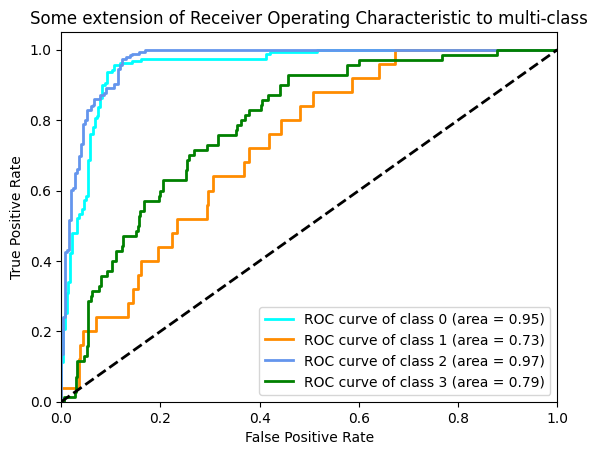

In [445]:
# Binarize the output labels
y_bin = label_binarize(y, classes=[1, 2, 3, 4])
n_classes = y_bin.shape[1]

# Split the data again, but this time with the binarized y
X_train, X_test, y_train, y_test = train_test_split(X, y_bin, test_size=0.2, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Learn to predict each class against the other using the gnb classifier
classifier = OneVsRestClassifier(gnb)
y_score = classifier.fit(X_train_scaled, y_train).predict_proba(X_test_scaled)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i, color in zip(range(n_classes), cycle(['aqua', 'darkorange', 'cornflowerblue', 'green'])):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver Operating Characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

随机森林

In [479]:
from sklearn.model_selection import GridSearchCV

# 假设df_new是你的DataFrame
X = df_new.drop('States', axis=1)  # 使用DataFrame的所有列作为特征，除了'states'列
y = df_new['States']  # 'states'是我们要预测的目标列

# 把数据分为80%的训练集和20%的测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 设置要搜索的参数网格
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30]
}

# 创建GridSearchCV对象
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5)

# 执行网格搜索
grid_search.fit(X_train, y_train)

# 打印最佳参数
print('Best parameters: ', grid_search.best_params_)

# 使用最佳参数重新训练模型
clf = grid_search.best_estimator_
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# 计算并打印准确率
accuracy_rf = accuracy_score(y_test, y_pred)
print('Accuracy of RandomForest: ' + str(accuracy_rf))

Best parameters:  {'max_depth': None, 'n_estimators': 50}
Accuracy of RandomForest: 0.9068181818181819


In [480]:
# 创建Random Forest分类器
clf = RandomForestClassifier(n_estimators=50, random_state=42)

# 用训练集训练模型
clf.fit(X_train, y_train)

# 使用测试集进行预测
y_pred = clf.predict(X_test)

# 计算并打印准确率
accuracy_rf = accuracy_score(y_test, y_pred)
print('Accuracy: ' + str(accuracy_rf))

Accuracy: 0.9068181818181819


In [481]:
scores = cross_val_score(clf, X, y, cv=5, scoring='f1_macro')

print('Cross-validation scores: ', scores)

# 平均交叉验证得分
print('Average cross-validation score: ', scores.mean())

Cross-validation scores:  [0.72120047 0.71685691 0.72620412 0.75648574 0.49497606]
Average cross-validation score:  0.6831446627560017


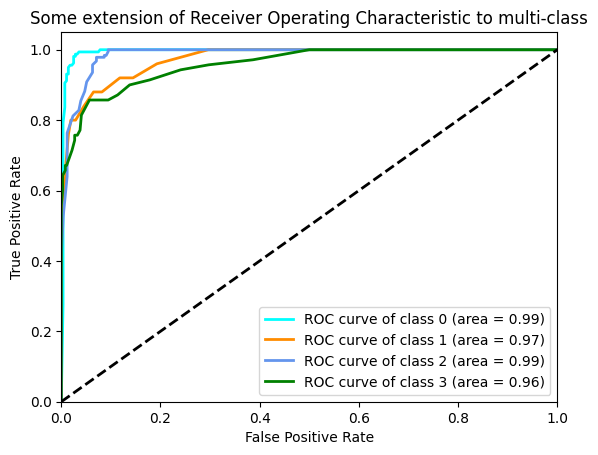

In [482]:
# Binarize the output labels
y_bin = label_binarize(y, classes=[1, 2, 3, 4])
n_classes = y_bin.shape[1]

# Split the data again, but this time with the binarized y
X_train, X_test, y_train, y_test = train_test_split(X, y_bin, test_size=0.2, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Learn to predict each class against the other using the clf classifier
classifier = OneVsRestClassifier(clf)
y_score = classifier.fit(X_train_scaled, y_train).predict_proba(X_test_scaled)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i, color in zip(range(n_classes), cycle(['aqua', 'darkorange', 'cornflowerblue', 'green'])):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver Operating Characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

SVM

In [486]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV

X = df_new.drop('States', axis=1)
y = df_new['States']

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# 设置参数搜索范围
parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10, 100], 'gamma':[0.1, 1, 10]}

# 创建SVM分类器
svc = svm.SVC()

# 创建GridSearchCV对象
clf = GridSearchCV(svc, parameters)

# 执行网格搜索
clf.fit(X_train, y_train)

# 打印最优参数
print("Best parameters:", clf.best_params_)

# 使用最优参数模型进行预测
y_pred = clf.predict(X_test)

# 计算准确率
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy of SVM with best parameters: ', accuracy)

Best parameters: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
Accuracy of SVM with best parameters:  0.9772727272727273


In [496]:
# 使用SVM训练模型
clf_svm = OneVsRestClassifier(SVC(kernel='rbf', C=10, gamma=0.1, probability=True))
clf_svm.fit(X_train, y_train)
y_pred_svm = clf_svm.predict(X_test)

# 计算并打印SVM的准确率
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print('Accuracy of SVM: ' + str(accuracy_svm))

Accuracy of SVM: 0.9545454545454546


In [497]:
scores = cross_val_score(clf_svm, X, y, cv=5, scoring='f1_macro')

print('Cross-validation scores: ', scores)

# 平均交叉验证得分
print('Average cross-validation score: ', scores.mean())

Cross-validation scores:  [0.26075116 0.3202076  0.35442549 0.36870569 0.23440753]
Average cross-validation score:  0.3076994937374471


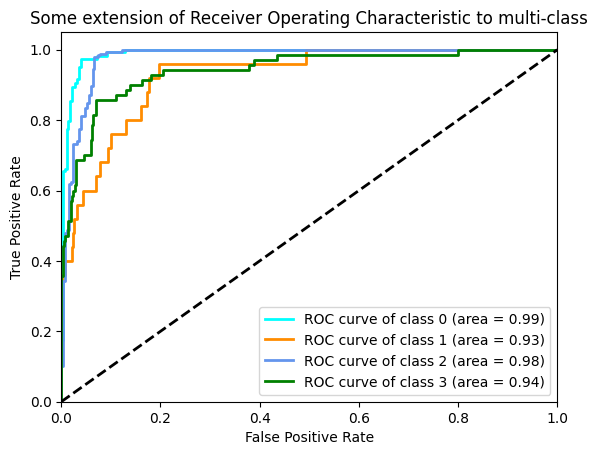

In [498]:
# Binarize the output labels
y_bin = label_binarize(y, classes=[1, 2, 3, 4])
n_classes = y_bin.shape[1]

# Split the data again, but this time with the binarized y
X_train, X_test, y_train, y_test = train_test_split(X, y_bin, test_size=0.2, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Learn to predict each class against the other using the clf_svm classifier
classifier = OneVsRestClassifier(clf_svm)
y_score = classifier.fit(X_train_scaled, y_train).predict_proba(X_test_scaled)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i, color in zip(range(n_classes), cycle(['aqua', 'darkorange', 'cornflowerblue', 'green'])):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver Operating Characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

逻辑回归

In [499]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

X = df_new.drop('States', axis=1)
y = df_new['States']

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 设置参数搜索范围
parameters = {'C':[0.01, 0.1, 1, 10, 100], 'penalty':['l1', 'l2', 'elasticnet', 'none']}

# 创建逻辑回归模型
lr = LogisticRegression()

# 创建GridSearchCV对象
clf = GridSearchCV(lr, parameters)

# 执行网格搜索
clf.fit(X_train, y_train)

# 打印最优参数
print("Best parameters:", clf.best_params_)

# 使用最优参数模型进行预测
y_pred = clf.predict(X_test)

# 计算准确率
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy of Logistic Regression with best parameters: ', accuracy)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

Best parameters: {'C': 100, 'penalty': 'l2'}
Accuracy of Logistic Regression with best parameters:  0.8136363636363636


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

In [501]:
# 使用逻辑回归训练模型
clf_lr = LogisticRegression(C=100, penalty='l2')
clf_lr.fit(X_train, y_train)
y_pred_lr = clf_lr.predict(X_test)

# 计算并打印逻辑回归的准确率
accuracy_lr = accuracy_score(y_test, y_pred_lr)
print('Accuracy of Logistic Regression: ' + str(accuracy_lr))


Accuracy of Logistic Regression: 0.8136363636363636


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [502]:
scores = cross_val_score(clf_lr, X, y, cv=5, scoring='f1_macro')

print('Cross-validation scores: ', scores)

# 平均交叉验证得分
print('Average cross-validation score: ', scores.mean())

Cross-validation scores:  [0.324689   0.57240831 0.54526082 0.53973508 0.52105011]
Average cross-validation score:  0.5006286641789596


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

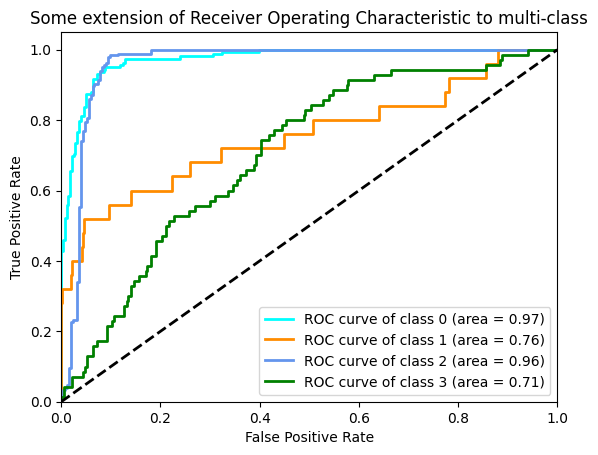

In [503]:
# Binarize the output labels
y_bin = label_binarize(y, classes=[1, 2, 3, 4])
n_classes = y_bin.shape[1]

# Split the data again, but this time with the binarized y
X_train, X_test, y_train, y_test = train_test_split(X, y_bin, test_size=0.2, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Learn to predict each class against the other using the clf_lr classifier
classifier = OneVsRestClassifier(clf_lr)
y_score = classifier.fit(X_train_scaled, y_train).predict_proba(X_test_scaled)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i, color in zip(range(n_classes), cycle(['aqua', 'darkorange', 'cornflowerblue', 'green'])):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver Operating Characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

MLP

In [504]:
from sklearn.model_selection import GridSearchCV

#神经网络MLP
# 分离特征和目标变量
X = df_new.drop('States', axis=1)
y = df_new['States']

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 设置要搜索的参数网格
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50,50)],
    'learning_rate': ['constant', 'invscaling', 'adaptive']
}

# 创建GridSearchCV对象
grid_search = GridSearchCV(MLPClassifier(max_iter=300, random_state=42), param_grid, cv=5)

# 执行网格搜索
grid_search.fit(X_train_scaled, y_train)

# 打印最佳参数
print('Best parameters: ', grid_search.best_params_)

# 使用最佳参数重新训练模型
clf_mlp = grid_search.best_estimator_
clf_mlp.fit(X_train_scaled, y_train)
y_pred_mlp = clf_mlp.predict(X_test_scaled)

# 计算并打印准确率
accuracy_mlp = accuracy_score(y_test, y_pred_mlp)
print('Accuracy of MLP: ' + str(accuracy_mlp))

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iteration

Best parameters:  {'hidden_layer_sizes': (100,), 'learning_rate': 'constant'}
Accuracy of MLP: 0.8931818181818182


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


In [505]:
# 数据标准化
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 使用神经网络（多层感知器）训练模型
clf_mlp = MLPClassifier(hidden_layer_sizes=(100, ), max_iter=300, random_state=42)
clf_mlp.fit(X_train_scaled, y_train)
y_pred_mlp = clf_mlp.predict(X_test_scaled)

# 计算并打印神经网络的准确率
accuracy_mlp = accuracy_score(y_test, y_pred_mlp)
print('Accuracy of MLP: ' + str(accuracy_mlp))

Accuracy of MLP: 0.8931818181818182


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


In [506]:
scores = cross_val_score(clf_mlp, X, y, cv=5, scoring='f1_macro')

print('Cross-validation scores: ', scores)

# 平均交叉验证得分
print('Average cross-validation score: ', scores.mean())

Cross-validation scores:  [0.43302138 0.43941426 0.43997443 0.44073679 0.41276427]
Average cross-validation score:  0.43318222515609683


In [507]:
# 创建一个新的 DataFrame 来保存测试集中的实际值和预测值
results_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_mlp})

# 打印结果
print(results_df)

      Actual  Predicted
427        3          3
1128       4          1
367        1          1
1771       1          1
350        1          1
...      ...        ...
1182       1          1
2003       3          3
479        4          4
680        3          3
1435       3          3

[440 rows x 2 columns]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iteration

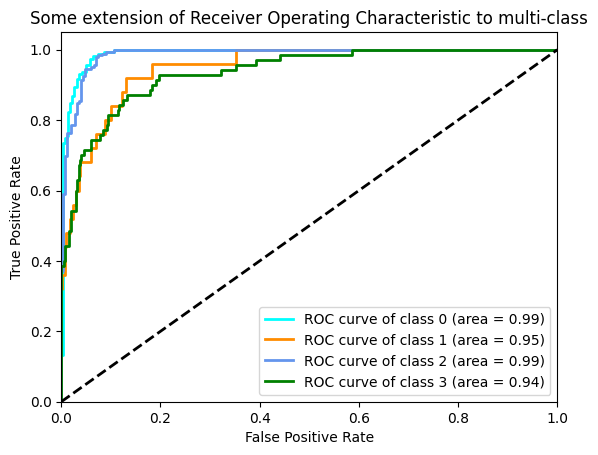

In [508]:
# Binarize the output labels
y_bin = label_binarize(y, classes=[1, 2, 3, 4])
n_classes = y_bin.shape[1]

# Split the data again, but this time with the binarized y
X_train, X_test, y_train, y_test = train_test_split(X, y_bin, test_size=0.2, random_state=42)

# Standardize the data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Learn to predict each class against the other using the MLP classifier
classifier = OneVsRestClassifier(clf_mlp)
y_score = classifier.fit(X_train_scaled, y_train).predict_proba(X_test_scaled)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i, color in zip(range(n_classes), cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'purple'])):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver Operating Characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

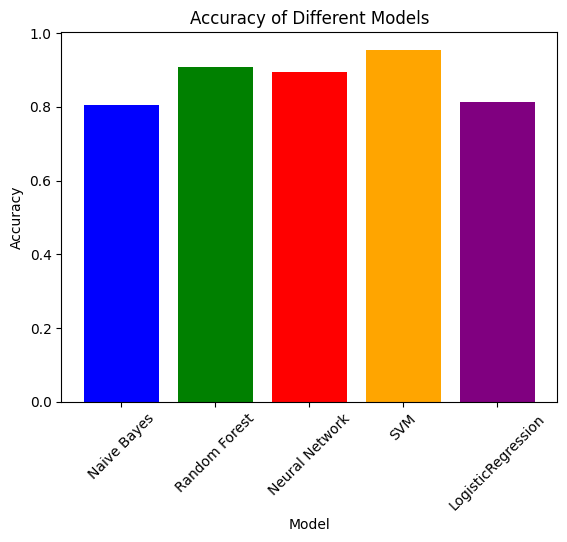

In [509]:
# 创建一个字典，其中包含每种模型的名称和相应的准确率
accuracy_scores = {'Naive Bayes': accuracy_nb, 'Random Forest': accuracy_rf, 'Neural Network': accuracy_mlp, 'SVM': accuracy_svm, 'LogisticRegression': accuracy_lr}

# 创建一个条形图
plt.bar(accuracy_scores.keys(), accuracy_scores.values(), color=['blue', 'green', 'red', 'orange', 'purple'])
plt.xticks(rotation=45)

# 添加标题和标签
plt.title('Accuracy of Different Models')
plt.xlabel('Model')
plt.ylabel('Accuracy')

# 显示图形
plt.show()